In [1]:
import pandas as pd
import numpy as np
import os
os.chdir('/home/lichi/jupiter/imaginarium/')
from random import sample

from PIL import Image
from keras.applications.vgg19 import VGG19
from keras.models import Model
from keras.preprocessing import image
from keras.applications.imagenet_utils import preprocess_input
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from sklearn.metrics import mean_squared_error

from visual import tools, evaluation

/usr/local/lib/python2.7/dist-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [2]:
path_to_model =  '/home/lichi/jupiter/imaginarium/pretrained_models/coco.npz'
path_to_model_f30k =  '/home/lichi/jupiter/imaginarium/pretrained_models/f30k.npz'
model = tools.load_model(path_to_model = path_to_model)
model_f30k = tools.load_model(path_to_model = path_to_model_f30k)
#evaluation.evalrank(model, data='f8k', split='test')

/home/lichi/jupiter/imaginarium/pretrained_models/coco.npz
Loading dictionary...
Creating inverted dictionary...
Loading model options...
Loading model parameters...
Compiling sentence encoder...
Compiling image encoder...
Packing up...
/home/lichi/jupiter/imaginarium/pretrained_models/f30k.npz
Loading dictionary...
Creating inverted dictionary...
Loading model options...
Loading model parameters...
Compiling sentence encoder...
Compiling image encoder...
Packing up...


#### Читаем картинки, строим эмбеддинги и извлекаем из них VGG19 фичи

In [3]:
base_model = VGG19(weights='imagenet', include_top=True)
model_vgg19 = Model(input=base_model.input, output=base_model.get_layer('fc2').output)

paths_images = os.listdir('images')
img_list = []
feat_list = []
for path in paths_images:
    print path
    if path!='.ipynb_checkpoints':
        img=mpimg.imread('images/' + path,0)
        img_crop = img[30:-30,30:-211]
        h = img_crop.shape[0]
        w = img_crop.shape[1]
        img16 = []
        feat16 = []
        for i in np.arange(0,1,0.5):
            for j in np.arange(0,1,0.25):
                pic = img_crop[int(h*i):int(h*(i+1/2.)),int(w*j):int(w*(j+1/4.))]
                pil = Image.fromarray(pic)
                path_save = 'images_preprocessed/'+path[:-5]+str(i)+str(j)+ ".jpeg"
                pil.save(path_save)
                img = image.load_img(path_save, target_size=(224, 224))
                pic = image.img_to_array(img)
                pic = np.expand_dims(pic, axis=0)
                pic = preprocess_input(pic)
                features = model_vgg19.predict(pic)
                img16.append(img)
                feat16.append(features)
                
        img_list += img16
        feat_list += feat16

/usr/local/lib/python2.7/dist-packages/ipykernel_launcher.py:2: UserWarning: Update your `Model` call to the Keras 2 API: `Model(outputs=Tensor("fc..., inputs=Tensor("in...)`
  


img 17.jpeg
img 4.jpeg
img 16.jpeg
img 3.jpeg
img 8.jpeg
img 20.jpeg
img 23.jpeg
img 18.jpeg
img 15.jpeg
img 13.jpeg
img 2.jpeg
img 22.jpeg
.ipynb_checkpoints
img 14.jpeg
img 11.jpeg
img 9.jpeg
img 7.jpeg
img 21.jpeg
img 10.jpeg
img 6.jpeg
img 19.jpeg
img 12.jpeg
img 5.jpeg


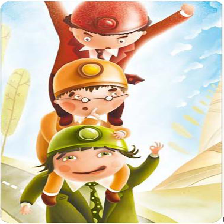

In [4]:
i = 50
img_list[i]

In [5]:
feat_list = [x.reshape(4096) for x in feat_list]
image_vectors = tools.encode_images(model, feat_list)
image_vectors_f30k = tools.encode_images(model_f30k, feat_list)

#### Берем топ-частотных слов

In [6]:
#words = pd.read_csv('words/4k_word_list.txt', sep = ',', header = -1)[0]
words = pd.read_csv('words/top1000_words.txt', sep = ',', header = -1).T[0]
words = np.array([x.replace(' ', '') for x in words])
words_vectors = tools.encode_sentences(model, words, verbose=True)
words_vectors_f30k = tools.encode_sentences(model_f30k, words, verbose=True)

1
1


#### Сохраняем представления для картинок в имаджинариуме и слов

In [7]:
import pickle
with open('preprocessed_data/words_coco_vectors.pickle', 'wb') as f:
    pickle.dump(words_vectors, f)
with open('preprocessed_data/image_coco_vectors.pickle', 'wb') as f:
    pickle.dump(image_vectors, f)

##### Ищем ближайшие k слова к картинке, а потом смотрим, встретилась ли в топе близких к этим словам k картинкам, исходная картинка

In [8]:
tmp_is_pic_near_pic = []
k_range = [5]
k_mean = []
for k in k_range:
    print k
    for ind_pic in range(len(img_list)):
        ind_pic = 0
        mse_picture = np.array([mean_squared_error(image_vectors[ind_pic], x)
                                for x in words_vectors])
        idx_words = np.argpartition(mse_picture, k)
        is_pic_near_pic = []
        for ind_word in list(idx_words[:k]):
            mse_words = np.array([mean_squared_error(words_vectors_f30k[ind_word], x)
                                for x in image_vectors_f30k])
            idx_images = np.argpartition(mse_words, k)[:k]
            tmp_is_pic_near_pic.append(ind_pic in idx_images)
        is_pic_near_pic = np.mean(tmp_is_pic_near_pic)
    k_mean.append(np.mean(tmp_is_pic_near_pic))

5


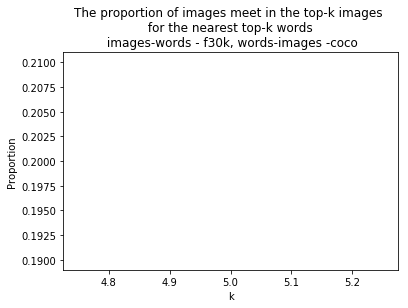

In [9]:
plt.plot(k_range, k_mean)
plt.title('The proportion of images meet in the top-k images \n for the nearest top-k words \n images-words - f30k, words-images -coco')
plt.xlabel('k')
plt.ylabel('Proportion')
plt.show()


### Пишем сетку

Берем 5 случайных картинок, из них выбираем одну

1) y - ohe номера картинки. 

2) X1 -  расстояние от картинки до топ 5 слов( часть речи, длина этих слов, сколько раз эти слова встречаются в топ-5 других картинок)

3) X2 - расстояние от полученного среднего вектора слов до 5 картинок, сколько раз картинки встречаются в топ-5 этих слов

4) Лосс - логлосс при обучении 2 игрока, при обучении 1 игрока - 1.5*p*(1-p)*(1-p) + p*p*(1-p)*1.5




### Строим модель

Матрица, в какой доле картинок слово в топ-5, расстояния от картинкок до слов

In [10]:
k = 5
idx_images_array = []
mse_images_array = []
mse_images_top_array = []
for i in range(len(words_vectors)):
    mse_words = np.array([mean_squared_error(words_vectors[i], x)
                                    for x in image_vectors])
    idx_images = np.argpartition(mse_words, k)[:k]
    idx_images_array.append([1 if x in idx_images else 0 for x in range(len(mse_words))])
    mse_images_array.append(mse_words)
    mse_images_top_array.append(mse_words[idx_images])
idx_images_array = np.array(idx_images_array)
mse_images_array = np.array(mse_images_array)
mse_images_top_array = np.array(mse_images_top_array)

In [11]:
idx_images_array

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [1, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]])

In [69]:
i = 180
words[i]

'copper'

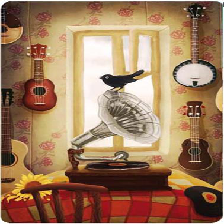

In [70]:
idx_images_array1 = np.array([mean_squared_error(words_vectors[i], x)
                                    for x in image_vectors])
ind = np.argpartition(idx_images_array1, k)[:k]
img_list[ind[0]]


In [14]:
norm_idx_images_array = idx_images_array.sum(axis = 0) / float(idx_images_array.sum())

Матрица, в какой доле слов, эта картинка в топ-5

In [71]:
k = 5
idx_words_array = []
mse_words_array = []
mse_words_top_array = []
for i in range(len(image_vectors)):
    mse_words = np.array([mean_squared_error(image_vectors[i], x)
                                    for x in words_vectors])
    idx_words = np.argpartition(mse_words, k)[:k]
    idx_words_array.append([1 if x in idx_words else 0 for x in range(len(mse_words))])
    mse_words_array.append(mse_words)
    mse_words_top_array.append(mse_words[idx_words])
idx_words_array = np.array(idx_words_array)
mse_words_array = np.array(mse_words_array)
mse_words_top_array = np.array(mse_words_top_array)

In [72]:
np.where(idx_words_array[0]==1)

(array([317, 503, 560, 610, 995]),)

In [73]:
norm_idx_words_array = idx_words_array.sum(axis = 0) / float(idx_words_array.sum())

### Обучающая выборка

In [ ]:
X_ind, y_ind, y, X1 = [], [], [], []
X_img_freq = []
num_samples = 100000
k = 10
for i in range(num_samples):
    X_ind.append(np.array(sample(range(1,len(img_list)), k)))
    y_ind.append(sample(X_ind[i], 1))
    y.append(np.array([1 if x==y_ind[i] else 0 for x in X_ind[i]]))
    dist_words = mse_words_top_array[y_ind[i]]
    freq_word = norm_idx_words_array[np.where(idx_words_array[0]==1)]
    X1.append(np.concatenate([dist_words.reshape(k,1), freq_word.reshape(k,1)], axis = 1))
    freq_image = norm_idx_images_array[np.where(idx_images_array[0]==1)]
    X_img_freq.append(freq_word)

In [ ]:
idx_images_array

In [ ]:
X2 = image_vectors[X_ind].reshape(num_samples,1024,k)
X1 = np.array(X1).reshape(num_samples,2,k)
y = np.array(y).reshape(num_samples,1,k)
X3 = X2.reshape(num_samples,k,1024)
X30 = X3[:,0,:].reshape(num_samples,1024)
X31 = X3[:,1,:].reshape(num_samples,1024)
X_img_freq = np.array(X_img_freq)

### Сетка, которая пока просто подбирает идеальное слово под случайно выбранную картинку для 1 агента,  а потом 2 агент просто выбирает ближайшее слово (или учит как выбирать dense слоем (тоже такой штраф за небанальность))

In [9]:
def mean_squared_error_keras(y_true, y_pred):
    return K.mean(K.square(y_pred - y_true), axis=2)
k = 10
from keras.models import Model
import keras.backend as K
from keras.layers import Conv1D,Activation, Reshape, Conv2D,Input, Dense, dot, multiply, add, concatenate, Lambda

In [10]:

# Сетка, которая пока просто подбирает идеальное слово под случайно выбранную картинку для 1 агента, 
# а потом 2 агент просто выбирает ближайшее слово

# Входы 10 ближайших пар, заранее сгенерированные расстояния между ближайшими словами и картинками, и частоту топ 10 
# близости каждого слова к ближайшим 10 картинкам
inputs1 = Input(shape=(2,k))
# Эмбеддинги для слов
inputs2 = Input(shape=(1024,k))
inputs21 = Input(shape=(k,1024))
# OHE-вектор, какое слово было истинным
inputs3 = Input(shape=(1,k))
#  Учим свертку, которая делает штраф-поощрения за банальность (дистанция между словами, попсовость слов)
# На выходе получили веса для каждого слова
conv1d = Conv1D(k, (2), activation='softmax', padding = 'valid')(inputs1)
#predictions = Dense(5, activation='softmax')(conv1d)
# усредняем слова с весами, выученными сверткой
merge_layer = multiply([conv1d, inputs2])
# делаем повтор, чтобы потом считать новые минимальные дистанции
sum_layer = Lambda(lambda x: K.repeat(K.sum(x, axis = 2), k), output_shape=(1024, k))(merge_layer)

# считаем разницу между полученными средними одного и другого
distance_layer = Lambda(lambda x: mean_squared_error_keras(x[0], x[1]),
                        output_shape=(1,k))([inputs21, sum_layer])

#features_img = concatenate([distance_layer, inputs3], axis = 1)
#output = Conv1D(5, (2), activation='softmax', padding = 'valid')(features_img)

# Выбираем правильный ответ (аналог агента)
output = Dense(k, activation='softmax')(distance_layer)

#подбираем картинки
model_keras = Model(inputs=[inputs1, inputs2, inputs21], outputs=output)
model_keras.compile(optimizer='rmsprop',
              loss='categorical_crossentropy',
              metrics=['accuracy'])





#### Отрисовать сетку

In [ ]:
from keras.utils import plot_model
plot_model(model_hard, to_file='model_hard.png')

from IPython.display import SVG
from keras.utils.vis_utils import model_to_dot

SVG(model_to_dot(model_keras).create(prog='dot', format='svg' ))


### Сетка, которая доучивает еще dense слой к эмбеддингам

#### Обучающая выборка 2 (Сделать генератор)

### Генератор

In [11]:
# Сэмплируем случайные k векторов
def generate_arrays_from_file(image_vectors,words_vectors, num_samples = 50, k = 10, num_words = 998):
    while 1:
        X_images = []
        y_true_image = []
        for i in range(num_samples):
            img = np.array(sample(range(1,len(image_vectors)), k))
            X_images.append(img)
            true_image = sample(img, 1)
            y_true_image.append(np.array([1 if x==true_image else 0 for x in X_images[i]]))
        # Эмбеддинги для всех картинок
        X_images = image_vectors[X_images].reshape(num_samples,1024,k)
        # Эмбеддинги для правильной картинки, размноженные 10 раз
        t =np.array(X_images)[:,:,np.argmax(y_true_image)]
        X_true_img = np.repeat(t.reshape(t.shape[0],t.shape[1],1),num_words,axis =2).reshape(num_samples, num_words, 1024)
        # Эмбеддинги для всех текстов
        X_all_texts = np.repeat(words_vectors.reshape(1, num_words, 1024),num_samples, axis = 0 )
        # Решейплю
        X_images = X_images.reshape(num_samples, k,1024)
        # Ответы
        y_true_image = np.array(y_true_image).reshape(num_samples,1, k)
        yield ([X_images, X_true_img, X_all_texts], y_true_image)
    #for i in range(0, len(X), batch_size):
    #    x = generator_w2vec.generator(X[i:i+batch_size])
    #    y_r = y[i:i+batch_size,:]
    #    yield ([x[0], x[1].reshape(batch_size, 50, 300)], y_r)
   

### Сетка

In [12]:
emb_dim = 100
k = 10
num_words = 998
# Вектора для k картинок
X_images_net = Input(shape=(k,1024), name = 'X_images_net')
# Вектор для правильной картинки, размноженной 1000 раз - по количеству слов
X_image_true_net = Input(shape=(num_words, 1024), name = 'X_image_true_net')
# Вектора для всех слов
X_text_all_net = Input(shape = (num_words, 1024), name = 'X_text_all_net')
# Вектор для того, какая картинка была авторской
y_true_image_net = Input(shape=(1,k), name = 'y_true_image_net')

conv_img_words2 = Dense(100, activation = 'softmax', name = 'dense_img_words2')
# Эмбеддинги для правильной картинки (размноженной по числу слов)
image_net2 = conv_img_words2(X_image_true_net)
# Эмбединги для слов
word_net2 = conv_img_words2(X_text_all_net)
# Считаю расстояния от картинки до текста, представляю картинку как взвешенную сумму слов
distance_layer2 = Lambda(lambda x: mean_squared_error_keras(x[0], x[1]),
                        output_shape=(1,num_words), name = 'distance_layer2')([image_net2, word_net2])
weights_for_words2 = Dense(num_words, activation='softmax', name = 'weights_for_words2')(distance_layer2)
# Меняем форму слоев, чтобы их перемножить
weights_for_words2_resh = Reshape((1,num_words), name = 'weights_for_words2_resh')(weights_for_words2)
word_net2_resh = Reshape((emb_dim,num_words), name = 'word_net2_resh')(word_net2)
# Перемножаем
merge_layer2 = multiply([weights_for_words2_resh, word_net2_resh], name = 'merge_layer2')
# Усредняем, получаем вектор для финального слова
sum_layer2 = Lambda(lambda x: K.sum(x, axis = 2), output_shape=(1,emb_dim), name = 'sum_layer2')(merge_layer2)
# Обрабатываем Dense слоем k картинок
image_all_net2 = conv_img_words2(X_images_net)
# Размножаем вектор для финального слова
final_word_vector_k = Lambda(lambda x: K.repeat(x, k), output_shape=(10, emb_dim),
                             name = 'final_word_vector_k')(sum_layer2)
# Считаем расстояния от полученного вектора слов до k картинок
distance_layer_final = Lambda(lambda x: mean_squared_error_keras(x[0], x[1]),
                        output_shape=(1,k),
                              name = 'distance_layer_final')([image_all_net2, final_word_vector_k])
# Подаем в Dense
#output2 = Activation('softmax', name = 'output2')(distance_layer_final)

output2 = Dense(k, activation = 'softmax', name = 'output2')(distance_layer_final)

#подбираем картинки
model_hard = Model(inputs=[X_images_net, X_image_true_net, X_text_all_net], outputs=output2)
model_hard.compile(optimizer='rmsprop',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

#
# Бейзлайн - количество угаданных слов или лосс по фиксированным image captioning эмбеддингам

### Фитим сетку на всех картинках из coco

In [13]:
path_coco_imgs = 'data_coco_flkr/coco_test_ims.npy'
images_coco = np.load(path_coco_imgs)
image_vectors_coco = tools.encode_images(model, images_coco)

In [14]:
image_vectors_coco.shape, image_vectors.shape

((5000, 1024), (176, 1024))

In [16]:
import keras
batch_size = 200
fun_train = generate_arrays_from_file(image_vectors_coco,words_vectors, num_samples = 50, k = 10, num_words = 998)
steps = 100
epochs = 2
tbCallBack = keras.callbacks.TensorBoard(log_dir='Graph', histogram_freq=0,  
          write_graph=True, write_images=True)
#tbCallback.set_model(tbCallBack)

model_hard.fit_generator(fun_train,steps, epochs, verbose=1, shuffle = True, callbacks=[tbCallBack]) #validation_steps=fun_val,

Epoch 1/2
100/100 [==============================] - 143s 1s/step - loss: 11.5121 - acc: 0.1054
Epoch 2/2
100/100 [==============================] - 139s 1s/step - loss: 11.5133 - acc: 0.0972


In [ ]:
import tensorflow as tf
from tensorflow.python import debug as tf_debug
import keras
keras.backend.set_session(
    tf_debug.TensorBoardDebugWrapperSession(tf.Session(), "lichi.haze.yandex.net:6007"))

## PCA, tsne
### Tensorbord
#### Выбирать не случайно топ- не хабные ближе
#### 


#### Проверяем, что все shapes сходятся

In [ ]:
X_images.shape, X_images_net

In [ ]:
X_true_img.shape, X_image_true_net

In [ ]:
X_all_texts.shape, X_text_all_net

In [ ]:
y_true_image.shape, output2

# Черновик

In [ ]:


model = VGG19(weights='imagenet', include_top=False)

img_path = 'images/' + path
img = image.load_img(img_path, target_size=(500, 500))
x = image.img_to_array(img)
x = np.expand_dims(x, axis=0)
x = preprocess_input(x)

features = model.predict(x)

#### Берем картинки из тестового сета

In [ ]:
images_coco = np.load('data_coco_flkr/coco_test_ims.npy')

In [ ]:
k = 400
plt.imshow(images_coco[k].reshape(64,64,1))
plt.show()

In [ ]:

%pylab inline
# чуть покрасивше картинки:
#pd.set_option('display.mpl_style', 'default')
import warnings
warnings.filterwarnings("ignore")
plt.rcParams['figure.figsize'] = 8, 6
plt.rcParams['axes.grid'] = True
pd.set_option('display.max_columns', None)
import matplotlib.pyplot as plt
import matplotlib as mpl
mpl.rcParams['font.family'] = 'Ubuntu'
plt.rc('text', usetex=False)
plt.rc('font', family='serif')
plt.rc('font', weight='bold')
plt.rc('xtick', labelsize=10) 
plt.rc('ytick', labelsize=10)
# чтобы был русский шрифт
from matplotlib import rc
font = {'family': 'Verdana',
        'weight': 'normal'}
rc('font', **font)

